In [53]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import csv
import node2vec
import itertools

# Creating the bipartite graph

In [4]:
B = nx.Graph()
documents = []
names = []
edges = []
# Add nodes with the node attribute "bipartite"
with open('../data/ccp_adjacency_list.csv') as all_names:
    name_reader = csv.reader(all_names)
    for row in name_reader:
        documents.append(row[0])
        for name in row[1:]:
            names.append(name)
            edges.append((row[0], name))
            
B.add_nodes_from(documents, bipartite=0)
B.add_nodes_from(names, bipartite=1)
B.add_edges_from(edges)

# remove nodes with 1 edge only

one_edge_nodes = []
for node in B.nodes:
    if len([n for n in B[node]]) <= 1:
        one_edge_nodes.append(node)

B.remove_nodes_from(one_edge_nodes)
nx.write_gml(B, '../data/bipartite_graph.gml')

5222
1032


# Clustering with Girvan Newman

In [56]:
from igraph import *
# either import or make your own like the one above
bipartite_graph = Graph.Read_GML('../data/bipartite_graph.gml')

# Girvan Newman clusters
gn_clusters = bipartite_graph.community_edge_betweenness().as_clustering()

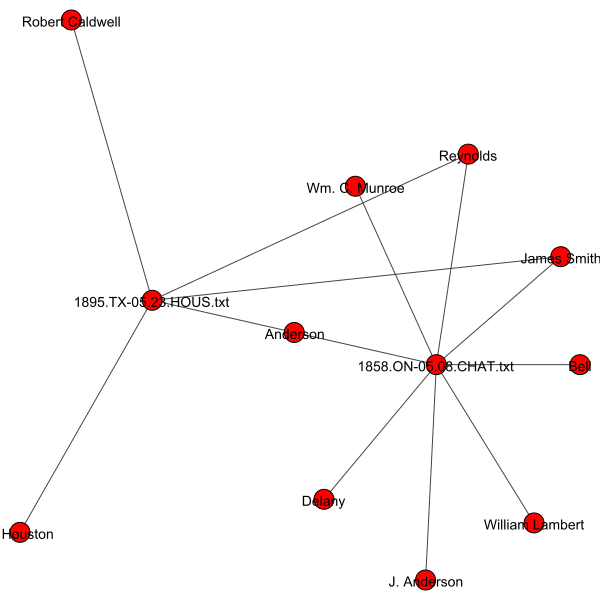

In [57]:
subgraph = gn_clusters.subgraph(15)
layout = subgraph.layout("rt_circular")
plot(subgraph, layout=layout)

## Creating cluster data in CSV format

In [ ]:
writer = csv.writer(open("../data/gn_clusters.csv", "w", newline=''))
writer.writerow(["cluster", "members"])
count = 0
for cluster in gn_clusters:
    members = [bipartite_graph.vs[member]["label"] for member in cluster]
    writer.writerow([count] + members)
    count += 1

## clusters in JSON for d3

In [16]:
import json
nodes = []
links = []
count = 0
for cluster in gn_clusters:
    nodes += [{"id" : bipartite_graph.vs[member]['label'], "group": count} for member in cluster]
    count += 1

for e in bipartite_graph.es:
    links += [{"source": bipartite_graph.vs[e.source]['label'], "target": bipartite_graph.vs[e.target]['label']}]

with open('../visualizations/gn_clusters.json', 'w') as gn_cluster_json:
    json.dump({"nodes": nodes, "links": links}, gn_cluster_json)

# Clustering with Louvain

In [58]:
# Louvain clusters
louvain_clusters = bipartite_graph.community_multilevel()

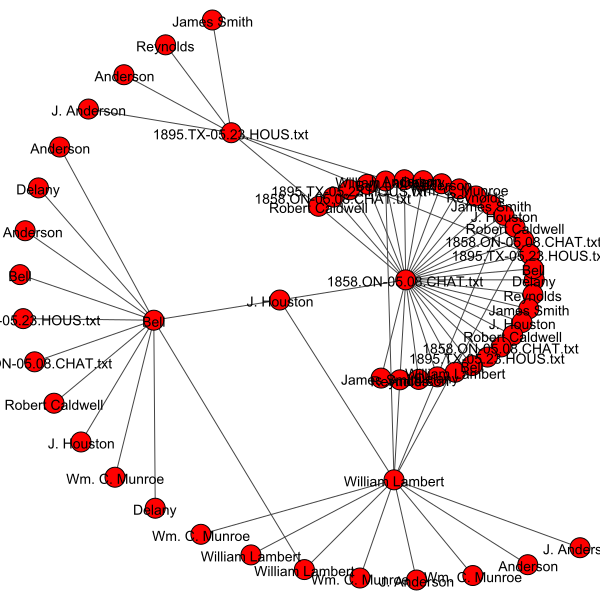

In [63]:
subgraph_l = louvain_clusters.subgraph(2)
layout_l = subgraph_l.layout("rt_circular")
plot(subgraph_l, layout=layout_l, vertex_label=subgraph.vs['label'])

## Creating cluster data in csv

In [17]:
writer = csv.writer(open("../data/louvain_clusters.csv", "w", newline=''))
writer.writerow(["cluster", "members"])
count = 0
for cluster in louvain_clusters:
    members = [bipartite_graph.vs[member]["label"] for member in cluster]
    writer.writerow([count] + members)
    count += 1

## clusters in JSON for d3

In [18]:
nodes = []
links = []
count = 0
for cluster in louvain_clusters:
    nodes += [{"id" : bipartite_graph.vs[member]['label'], "group": count} for member in cluster]
    count += 1

for e in bipartite_graph.es:
    links += [{"source": bipartite_graph.vs[e.source]['label'], "target": bipartite_graph.vs[e.target]['label']}]

with open('../data/louvain_clusters.json', 'w') as louvain_cluster_json:
    json.dump({"nodes": nodes, "links": links}, louvain_cluster_json)

# Clustering in Node2Vec

In [ ]:
# Precompute probabilities and generate walks
node2vec = node2vec.Node2Vec(B, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# try min_count = 100 and min_count = 500

# Any keywords acceptable by gensim.Word2Vec can be passed,
# `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

# Save embeddings for later use
model.wv.save_word2vec_format('../data/bipartite.emb')

# Save model for later use
model.save('../data/bipartite.model')

## Loading the node2vec model (using word2vec)

In [65]:
model = word2vec.Word2Vec.load('../data/bipartite.model')
X = model.wv[model.wv.vocab]
model.wv.most_similar('Anderson') #same man connected to Ontario and Texas

C:\Users\arshi\AppData\Roaming\Python\Python37\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Reynolds', 0.5838176012039185),
 ('John G. Britton', 0.5824978351593018),
 ('Miller', 0.57292640209198),
 ('James Smith', 0.5638746023178101),
 ('Robertson', 0.5500481724739075),
 ('G. W. Smith', 0.53349769115448),
 ('S. Jones', 0.4765819311141968),
 ('Joseph Henry Perkins', 0.4759955108165741),
 ('Marshall', 0.466139018535614),
 ('J. Brown', 0.4628164768218994)]

## Visualizing node2vec with TSNE
[Reference here](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

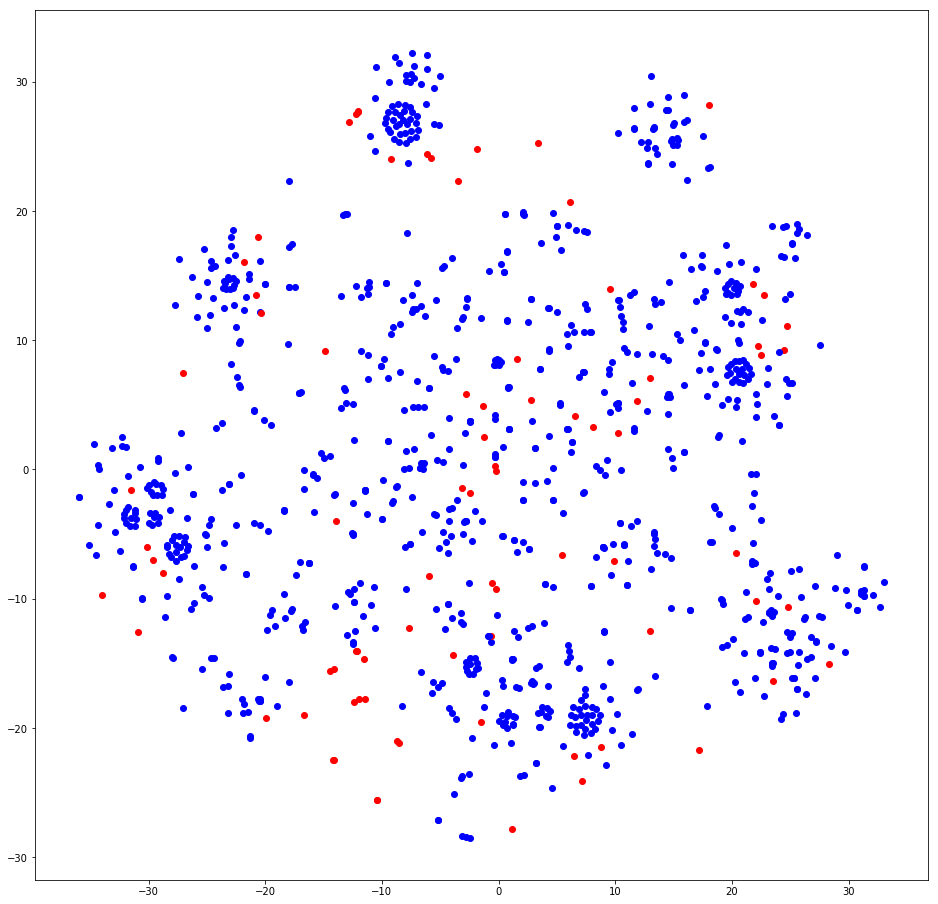

In [67]:
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model.wv[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 

for i in range(len(x)):
    node_color = "blue"
    if ".txt" in labels[i]:
        node_color = "red"
    plt.scatter(x[i],y[i], color=node_color)
#     plt.annotate(labels[i],
#                  xy=(x[i], y[i]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')
plt.show()